# Barclays Problem Statement (Beatrice Goh)


## Airfoil Noise dataset from UCI Machine Learning Repository
- https://archive.ics.uci.edu/ml/datasets/airfoil+self-noise

Airfoils produce a tonal noise when operating at low to moderate Reynolds number. This tonal noise can be annoying to the human ear and is problematic for the design of fans, compressors, helicopter rotors and unmanned air vehicles.

https://www.researchgate.net/publication/237077896_Airfoil_noise_measurements_at_various_angles_of_attack_and_low_Reynolds_number#:~:text=Airfoils%20produce%20tonal%20noise%20when%20operated%20at%20low-to-moderate,fans%2C%20compressors%2C%20helicopter%20rotors%20and%20unmanned%20air%20vehicles.

The goal of this project is to estimate the noise level of an airfoil based on the characteristics of 
- Frequency, in Hertzs.
- Angle of attack, in degrees.
- Chord length, in meters.
- Free-stream velocity, in meters per second.
- Suction side displacement thickness, in meters.

The output is scaled sound pressure level, in decibels. 

This notebook attempts to build a classification model to determine whether airfoil noise measurements are within acceptable range. Given the range of output values are between 100 - 140 decibels, the output will be grouped into 3 classes : 
- low sound level (100-113 decibels) 
- medium sound level (114-127 decibels) 
- high sound level (128-140 decibels)

## Import libraries and access dataset

In [148]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn


UsageError: Line magic function `%` not found.


In [2]:
# Open file and write data to numpy array 

data_list = []
with open('airfoil_self_noise.dat') as f:
    for line in f:
        
        # remove \n from end of string
        line1 = line.replace('\n','')
        
        # split string by delimiter
        rline = line1.split('\t')
        
        # combine data into one big list
        data_list.append(rline)
       
    # Convert to pandas dataframe, column names as per meta data
    df = pd.DataFrame(data_list, columns=['frequency','angle_of_attack','chord_length','velocity','thickness','sound_level'])

In [3]:
# Check data types and any missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   frequency        1503 non-null   object
 1   angle_of_attack  1503 non-null   object
 2   chord_length     1503 non-null   object
 3   velocity         1503 non-null   object
 4   thickness        1503 non-null   object
 5   sound_level      1503 non-null   object
dtypes: object(6)
memory usage: 70.6+ KB


In [4]:
# Convert data type from string to float

for n in df.columns: 
    df[n] = df[n].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   frequency        1503 non-null   float64
 1   angle_of_attack  1503 non-null   float64
 2   chord_length     1503 non-null   float64
 3   velocity         1503 non-null   float64
 4   thickness        1503 non-null   float64
 5   sound_level      1503 non-null   float64
dtypes: float64(6)
memory usage: 70.6 KB


## 1) Data Exploration & Visualisation

### Print 2 rows for sanity check to identify all the features present in the dataset and if the target matches with them.

In [5]:
df.head(2)

,frequency,angle_of_attack,chord_length,velocity,thickness,sound_level
0,800.0,0.0,0.3048,71.3,0.002663,126.201
1,1000.0,0.0,0.3048,71.3,0.002663,125.201


In [6]:
df.describe()

,frequency,angle_of_attack,chord_length,velocity,thickness,sound_level
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


### Comment on class imbalance with appropriate visualization method.

Visualisation of target value

Observation: As the target values are continuous in nature, the best way to represent the distribution is through a histogram.The graph is left skewed, with average sound level at 124.84 decibels and peak distribution between 125-130 decibels.


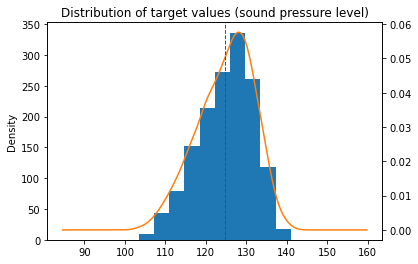

In [7]:
avg_value = round(df['sound_level'].mean(),2)

ax = df.sound_level.plot(kind='hist')
df.sound_level.plot(kind='kde', ax=ax, secondary_y=True)

plt.title('Distribution of target values (sound pressure level)')
plt.axvline(df['sound_level'].mean(), color='red', linestyle='dashed', linewidth=1)
# plt.annotate(f'Average sound level = {avg_value} decibels', xy=(0, 0), xytext=(2, 1.5),
#              arrowprops=dict(facecolor='black', shrink=0.05))
#plt.show()


print(f'Observation: As the target values are continuous in nature, the best way to represent the distribution is through a histogram.The graph is left skewed, with average sound level at {avg_value} decibels and peak distribution between 125-130 decibels.')


In [8]:
# Get min and max value of observations

print("min sound level : ",df['sound_level'].min())
print("max sound level : ",df['sound_level'].max())


min sound level :  103.38
max sound level :  140.987


In [9]:
# Convert output values into one of the 3 pre-defined classes

def map_score(x):
    if x <= 113:
        return 1
    elif x > 113 and x <= 127: 
        return 2
    elif x > 127: 
        return 3
        
df['class'] = df["sound_level"].apply(lambda x: map_score(x))

In [10]:
# Visualise dataset after addition of class labels

df.head()

,frequency,angle_of_attack,chord_length,velocity,thickness,sound_level,class
0,800.0,0.0,0.3048,71.3,0.002663,126.201,2
1,1000.0,0.0,0.3048,71.3,0.002663,125.201,2
2,1250.0,0.0,0.3048,71.3,0.002663,125.951,2
3,1600.0,0.0,0.3048,71.3,0.002663,127.591,3
4,2000.0,0.0,0.3048,71.3,0.002663,127.461,3


In [11]:
# Check distribution of classes

df['class'].value_counts()

2    775
3    639
1     89
Name: class, dtype: int64

It is observed that there is a class imbalance in the dataset, about 6% for class 1, 51.5% for class 2 and 42.5% for class 3.


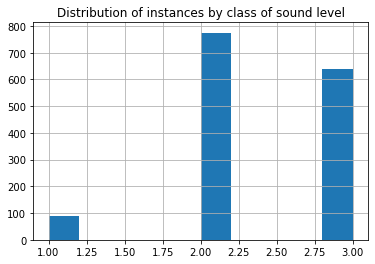

In [12]:
df['class'].hist()
plt.title('Distribution of instances by class of sound level')

print('It is observed that there is a class imbalance in the dataset, about 6% for class 1, 51.5% for class 2 and 42.5% for class 3.')

### Provide appropriate visualizations to get an insight about the dataset.

Visualisation of input features

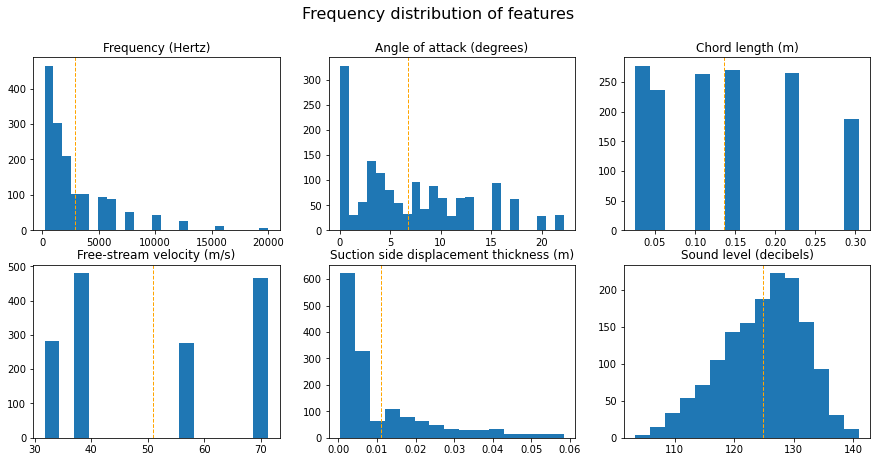

In [13]:
fig, ax = plt.subplots(2,3, figsize=(15, 7))

fig.suptitle('Frequency distribution of features',fontsize=16)

# Frequency distribution of frequency

ax[0,0].hist(df['frequency'], bins = 25)
ax[0,0].set_title('Frequency (Hertz)')
ax[0,0].axvline(df['frequency'].mean(), color='orange', linestyle='dashed', linewidth=1)


# Frequency distribution of angle of attack

ax[0,1].hist(df['angle_of_attack'], bins=25)
ax[0,1].set_title('Angle of attack (degrees)')
ax[0,1].axvline(df['angle_of_attack'].mean(), color='orange', linestyle='dashed', linewidth=1)
# plt.annotate(f'Average sound level = {avg_value} decibels', xy=(0, 0), xytext=(2, 1.5),
#             arrowprops=dict(facecolor='black', shrink=0.05))


# Frequency distribution of chord length

ax[0,2].hist(df['chord_length'], bins=15)
ax[0,2].set_title('Chord length (m)')
ax[0,2].axvline(df['chord_length'].mean(), color='orange', linestyle='dashed', linewidth=1)

# Frequency distribution of velocity

ax[1,0].hist(df['velocity'],bins=15)
ax[1,0].set_title('Free-stream velocity (m/s)')
ax[1,0].axvline(df['velocity'].mean(), color='orange', linestyle='dashed', linewidth=1)

# Frequency distribution of thickness

ax[1,1].hist(df['thickness'], bins=15)
ax[1,1].set_title('Suction side displacement thickness (m)')
ax[1,1].axvline(df['thickness'].mean(), color='orange', linestyle='dashed', linewidth=1)

# Frequency distribution of sound level
# Although sound level is an output feature, its distribution is also added here for easy viewing.

ax[1,2].hist(df['sound_level'], bins=15)
ax[1,2].set_title('Sound level (decibels)')
ax[1,2].axvline(df['sound_level'].mean(), color='orange', linestyle='dashed', linewidth=1)

plt.show()

#### Commentary on input features 

1. Frequency - Distribution is highly skewed to the right, with majority of the occurrences with frequencies below 2500Hz.
2. Angle of attack - Distribution is downward sloping, with majority of the occurrences with an angle of attack below 5 degrees.
3. Chord length - About one-third of the instances have chord length 0.05m or less. The remainder of the instances are fairly evenly distributed across chord length ranging from 0.1m to 0.3m. 
4. Free-stream velocity - does not appear to have a shape of a normal continuous distribution but tends towards 4 groups of values, as seen by the 4 bars in the histogram. 
5. Suction side displacement thickness - More than 60% of the instances had thickness of 0.005m or less. The remaining instances were distributed in a right skewed distribution, with outlier values going up to 0.06m. 


### Do the correlational analysis on the dataset.

Provide a visualization for the same. Will this correlational analysis have effect on feature selection that you will perform in the next step? Justify your answer. Answer without justification will not be awarded marks.

The input features do not appear to be correlated to the target value (sound value) as their correlation co-efficients are less than 0.4. The input features also do not appear to be collinear to one another as the correlation co-efficients are less than 0.8.


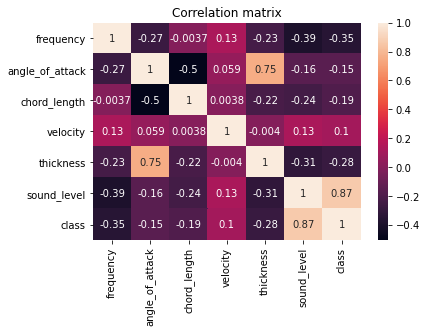

In [14]:
# plotting the heatmap for correlation
ax = sns.heatmap(df.corr(), annot=True)
plt.title('Correlation matrix')

print("The input features do not appear to be correlated to the target value (sound value) as their correlation co-efficients are less than 0.4. The input features also do not appear to be collinear to one another as the correlation co-efficients are less than 0.8.")


## 2) Data Pre-processing and cleaning

Do the appropriate pre-processing of the data like identifying NULL or Missing Values if any, handling of outliers if present in the dataset, skewed data etc.

In [15]:
# No missing values observed

df.isna().value_counts()

frequency  angle_of_attack  chord_length  velocity  thickness  sound_level  class
False      False            False         False     False      False        False    1503
dtype: int64

In [16]:
# Feature importance


In [17]:
# Split data into x and y values

x = df.iloc[:,0:4]
y = df.iloc[:,-1]

In [101]:
# Split dataset into test and train data set
# shuffle will randomise and shuffle the data before split

from sklearn import model_selection

# Case 1
X_train1, X_test1, Y_train1, Y_test1 = model_selection.train_test_split(x, y, test_size = 0.2, shuffle = True)

# Case 2
X_train2, X_test2, Y_train2, Y_test2 = model_selection.train_test_split(x, y, test_size = 0.9, shuffle = True)

In [102]:
# Features have values at different scales
# Use fit-transform to standardize the values

# scaling data using Standard scaler

from sklearn.preprocessing import StandardScaler

# Case 1
sc1 = StandardScaler()
sc1.fit_transform(X_train1)
sc1.transform(X_test1)

# Case 2
sc2 = StandardScaler()
sc2.fit_transform(X_train2)
sc2.transform(X_test2)

array([[-0.50828468, -0.36796674, -1.17364585, -1.15760687],
       [ 0.3660081 , -0.63096711, -0.34453968,  0.36382174],
       [-0.21685375, -1.20956792,  1.86641011, -0.65259486],
       ...,
       [-0.68314324,  0.45610109, -1.17364585,  0.36382174],
       [ 0.11829181,  0.45610109, -1.17364585, -0.65259486],
       [-0.74142943,  0.45610109, -1.17364585, -0.65259486]])

# Logistic Regression

## 3) Model building 


In [118]:
from sklearn import linear_model

# Case 1
clf1 = linear_model.LogisticRegression(solver='lbfgs',class_weight='balanced',random_state=123)
clf1.fit(X_train1, Y_train1)

# Case 2
clf2 = linear_model.LogisticRegression(solver='lbfgs',class_weight='balanced',random_state=123)
clf2.fit(X_train2, Y_train2)

C:\Users\gohch\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=123)

In [119]:
from sklearn import metrics

Y_pred1 = clf.predict(X_test1)
cf_matrix1 = metrics.confusion_matrix(Y_test1, Y_pred1)
print("Confusion Matrix case 1\n", cf_matrix1)
print("Accuracy score for Case 1:", metrics.accuracy_score(Y_test1, Y_pred1))
print("\n")

Y_pred2 = clf.predict(X_test2)
cf_matrix2 = metrics.confusion_matrix(Y_test2, Y_pred2)
print("Confusion Matrix case 2\n",cf_matrix2)
print("Accuracy score for Case 2:", metrics.accuracy_score(Y_test2, Y_pred2))

Confusion Matrix case 1
 [[17  1  0]
 [55 43 66]
 [14 22 83]]
Accuracy score for Case 1: 0.4750830564784053


Confusion Matrix case 2
 [[ 70   7   3]
 [207 237 253]
 [ 56 115 405]]
Accuracy score for Case 2: 0.5262379896526238


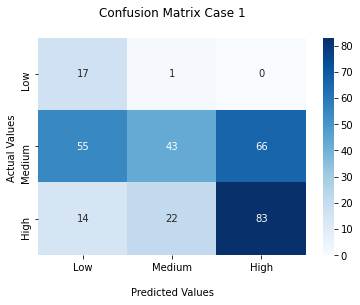

In [121]:
ax1 = sns.heatmap(cf_matrix1, annot=True, fmt = "d", cmap='Blues')

ax1.set_title('Confusion Matrix Case 1\n');
ax1.set_xlabel('\nPredicted Values')
ax1.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax1.xaxis.set_ticklabels(['Low','Medium','High'])
ax1.yaxis.set_ticklabels(['Low','Medium','High'])


## Display the visualization of the Confusion Matrix.
plt.show()



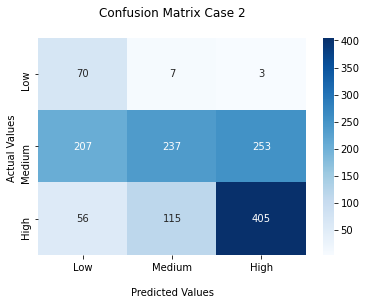

In [127]:
ax2 = sns.heatmap(cf_matrix2, annot=True, fmt = "d", cmap='Blues')

ax2.set_title('Confusion Matrix Case 2\n');
ax2.set_xlabel('\nPredicted Values')
ax2.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax2.xaxis.set_ticklabels(['Low','Medium','High'])
ax2.yaxis.set_ticklabels(['Low','Medium','High'])


## Display the visualization of the Confusion Matrix.
plt.show()



Explore k-fold cross validation


In [137]:
# Hyper parameter optimization

# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV


# parameters to build the model on

parameters = {'penalty': ['l2'],
              'class_weight': ['balanced'],
              'max_iter': [200,300,400,500],
              'tol': [0.000001, 0.000005, 0.00001, 0.00005, 0.0001],
              'solver': ['lbfgs','liblinear']} 

# specify number of folds for k-fold CV
#n_folds = 5
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# instantiate the model

logreg = linear_model.LogisticRegression()

# Fit SGD on training data
lg = GridSearchCV(estimator = logreg, param_grid = parameters, cv=cv, scoring= "accuracy")



Case 1

In [138]:
# Fit training data 

fit1 = lg.fit(X_train1, Y_train1)


In [139]:
# scores of GridSearch CV - accuracy
scores1 = fit1.cv_results_
pd.DataFrame(scores1).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_iter,param_penalty,param_solver,param_tol,params,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.047824,0.019622,0.001534,0.000501,balanced,200,l2,lbfgs,0.0,"{'class_weight': 'balanced', 'max_iter': 200, ...",...,0.558333,0.595833,0.580913,0.614108,0.5375,0.533333,0.566667,0.560165,0.026722,29
1,0.050439,0.022467,0.001327,0.000597,balanced,200,l2,lbfgs,0.0,"{'class_weight': 'balanced', 'max_iter': 200, ...",...,0.558333,0.595833,0.580913,0.614108,0.5375,0.533333,0.566667,0.560165,0.026722,29
2,0.049592,0.019813,0.001595,0.000486,balanced,200,l2,lbfgs,0.000001,"{'class_weight': 'balanced', 'max_iter': 200, ...",...,0.558333,0.595833,0.580913,0.614108,0.5375,0.533333,0.566667,0.560165,0.026722,29
3,0.051468,0.020867,0.001532,0.000499,balanced,200,l2,lbfgs,0.000005,"{'class_weight': 'balanced', 'max_iter': 200, ...",...,0.558333,0.595833,0.580913,0.614108,0.5375,0.533333,0.566667,0.560165,0.026722,29
4,0.050450,0.020550,0.001605,0.000493,balanced,200,l2,lbfgs,0.00001,"{'class_weight': 'balanced', 'max_iter': 200, ...",...,0.558333,0.595833,0.580913,0.614108,0.5375,0.533333,0.566667,0.560165,0.026722,29


In [140]:
# Extract hyperparameters of the best model 

best_model1 = fit1.best_estimator_

print('Best model:', best_model1)
print('Score: ', fit1.best_score_)
print('Best parameters:', fit1.best_params_)


Best model: LogisticRegression(class_weight='balanced', max_iter=200, solver='liblinear',
                   tol=1e-06)
Score:  0.6691424619640388
Best parameters: {'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-06}


Case 2

In [134]:
# Fit training data 

fit2 = lg.fit(X_train2, Y_train2)


C:\Users\gohch\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gohch\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [135]:
# scores of GridSearch CV - accuracy
scores2 = fit2.cv_results_
pd.DataFrame(scores2).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_iter,param_penalty,param_solver,param_tol,params,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021938,0.007329,0.001261,0.000443,balanced,200,l2,lbfgs,0.000001,"{'class_weight': 'balanced', 'max_iter': 200, ...",...,0.5,0.533333,0.466667,0.566667,0.5,0.533333,0.533333,0.508889,0.052305,25
1,0.022691,0.007266,0.001201,0.000410,balanced,200,l2,lbfgs,0.000005,"{'class_weight': 'balanced', 'max_iter': 200, ...",...,0.5,0.533333,0.466667,0.566667,0.5,0.533333,0.533333,0.508889,0.052305,25
2,0.024529,0.007358,0.001397,0.000487,balanced,200,l2,lbfgs,0.00001,"{'class_weight': 'balanced', 'max_iter': 200, ...",...,0.5,0.533333,0.466667,0.566667,0.5,0.533333,0.533333,0.508889,0.052305,25
3,0.024797,0.007949,0.001472,0.000495,balanced,200,l2,lbfgs,0.00005,"{'class_weight': 'balanced', 'max_iter': 200, ...",...,0.5,0.533333,0.466667,0.566667,0.5,0.533333,0.533333,0.508889,0.052305,25
4,0.024133,0.007787,0.001268,0.000435,balanced,200,l2,lbfgs,0.0001,"{'class_weight': 'balanced', 'max_iter': 200, ...",...,0.5,0.533333,0.466667,0.566667,0.5,0.533333,0.533333,0.508889,0.052305,25


In [136]:
# Extract hyperparameters of the best model 

best_model2 = fit2.best_estimator_

print('Best model:', best_model2)
print('Score: ', fit2.best_score_)
print('Best parameters:', fit2.best_params_)


Best model: LogisticRegression(class_weight='balanced', max_iter=200, solver='liblinear',
                   tol=0.0005)
Score:  0.5466666666666666
Best parameters: {'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0005}


## 4) Performance Evaluation

In [126]:
from sklearn import metrics

print('The classification report of Logistic Regression Case 1:\n {}'
      .format(metrics.classification_report(Y_test1, Y_pred1)))

The classification report of Logistic Regression Case 1:
               precision    recall  f1-score   support

           1       0.20      0.94      0.33        18
           2       0.65      0.26      0.37       164
           3       0.56      0.70      0.62       119

    accuracy                           0.48       301
   macro avg       0.47      0.63      0.44       301
weighted avg       0.59      0.48      0.47       301



In [128]:
from sklearn import metrics

print('The classification report of Logistic Regression Case 2:\n {}'
      .format(metrics.classification_report(Y_test2, Y_pred2)))

The classification report of Logistic Regression Case 2:
               precision    recall  f1-score   support

           1       0.21      0.88      0.34        80
           2       0.66      0.34      0.45       697
           3       0.61      0.70      0.65       576

    accuracy                           0.53      1353
   macro avg       0.49      0.64      0.48      1353
weighted avg       0.61      0.53      0.53      1353



# Decision Tree

## 3) Model Building

In [144]:
from sklearn import tree

# Fit a decision tree classifier
dt1 = tree.DecisionTreeClassifier(random_state=124)
dt1.fit(X_train1, Y_train1)

dt2 = tree.DecisionTreeClassifier(random_state=124)
dt2.fit(X_train2, Y_train2)


DecisionTreeClassifier(random_state=124)

In [145]:
Y_pred1 = dt1.predict(X_test1)

report1 = """
The evaluation report for case 1 is:
Confusion Matrix:
{}
Accuracy: {}
""".format(metrics.confusion_matrix(Y_test1, Y_pred1),
           metrics.accuracy_score(Y_test1, Y_pred1))
print(report1)


The evaluation report for case 1 is:
Confusion Matrix:
[[ 14   4   0]
 [  3 147  14]
 [  0  18 101]]
Accuracy: 0.8704318936877077



In [146]:
Y_pred2 = dt2.predict(X_test2)

report2 = """
The evaluation report for case 2 is:
Confusion Matrix:
{}
Accuracy: {}
""".format(metrics.confusion_matrix(Y_test2, Y_pred2),
           metrics.accuracy_score(Y_test2, Y_pred2))
print(report2)


The evaluation report for case 2 is:
Confusion Matrix:
[[ 34  44   2]
 [ 21 512 164]
 [  0 184 392]]
Accuracy: 0.6932742054693274



In [161]:
# Hyper parameter optimization

# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV


# parameters to build the model on

parameters = {'criterion': ['gini','entropy'],
              'max_depth': [3,4,5,6,7,None],
              'min_samples_leaf': [2,5,10],
              'class_weight': ['balanced']} 

# specify number of folds for k-fold CV
#n_folds = 5
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# instantiate the model

clf = tree.DecisionTreeClassifier()

# Fit SGD on training data
lg = GridSearchCV(estimator = clf, param_grid = parameters, cv=cv, scoring= "accuracy")



In [162]:
# Fit training data 

fit1 = lg.fit(X_train1, Y_train1)


In [163]:
# scores of GridSearch CV - accuracy
scores1 = fit1.cv_results_


In [164]:
# Extract hyperparameters of the best model 

best_model1 = fit1.best_estimator_

print('Best model:', best_model1)
print('Score: ', fit1.best_score_)
print('Best parameters:', fit1.best_params_)


Best model: DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=2)
Score:  0.7922879207007838
Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2}


In [165]:
# Fit training data 

fit2 = lg.fit(X_train2, Y_train2)


In [166]:
# scores of GridSearch CV - accuracy
scores2 = fit2.cv_results_


In [167]:
# Extract hyperparameters of the best model 

best_model2 = fit2.best_estimator_

print('Best model:', best_model2)
print('Score: ', fit2.best_score_)
print('Best parameters:', fit2.best_params_)


Best model: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_leaf=2)
Score:  0.5666666666666665
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2}


## 4) Performance Evaluation

In [143]:
print('The classification report of Decision Tree Case 1:\n {}'
      .format(metrics.classification_report(Y_test1, Y_pred1)))

The classification report of Decision Tree Case 1:
               precision    recall  f1-score   support

           1       0.82      0.78      0.80        18
           2       0.87      0.90      0.88       164
           3       0.88      0.85      0.86       119

    accuracy                           0.87       301
   macro avg       0.86      0.84      0.85       301
weighted avg       0.87      0.87      0.87       301



In [147]:
print('The classification report of Decision Tree Case 2:\n {}'
      .format(metrics.classification_report(Y_test2, Y_pred2)))

The classification report of Decision Tree Case 2:
               precision    recall  f1-score   support

           1       0.62      0.42      0.50        80
           2       0.69      0.73      0.71       697
           3       0.70      0.68      0.69       576

    accuracy                           0.69      1353
   macro avg       0.67      0.61      0.64      1353
weighted avg       0.69      0.69      0.69      1353

